In [1]:
%matplotlib inline
from IPython.display import clear_output
import time
from Environments.environments import all_envs, get_all_avail_envs, get_all_avail_test_envs, test_envs
from Agents.dqn_agent import DQN_Agent
from Agents.ppo_agent import PPO_Agent
from Models import fc, rnn
import matplotlib.pyplot as plt
import torch
import utils
from Curriculum_managers.random_curriculum import Random_Curriculum
from Curriculum_managers.paired_curriculum import PAIRED_Curriculum
from Curriculum_managers.paired_curriculum_no_regret_teacher_entropy import PAIRED_Curriculum_no_regret_entropy
from Curriculum_managers.paired_curriculum_no_regret_teacher_history import PAIRED_Curriculum_no_regret_history
from Curriculum_managers.paired_curriculum_no_regulator import Curriculum_Entropy_Only
from Curriculum_managers.paired_curriculum_no_regulator_history import Curriculum_Entropy_History
import plotly.express as px
import numpy as np
import plotly.io as pio
import cv2
pio.renderers.default = "browser"

In [2]:
def plot_res(vec, title):
    fig = px.line(x=range(len(np.convolve(vec, np.ones(100)/100,mode='valid'))), y=np.convolve(vec, np.ones(100)/100, mode='valid'), title=title)
    fig.show()

In [3]:
device = utils.init_torch()
env_names = get_all_avail_envs()
print(env_names[:8])

['SingleTaxiEnv', 'FrozenLakeEnv', 'AdversarialEnv', 'ReparameterizedAdversarialEnv', 'MiniAdversarialEnv', 'MiniReparameterizedAdversarialEnv', 'NoisyAdversarialEnv', 'MediumAdversarialEnv']


In [4]:
env = all_envs['MiniAdversarialEnv'](random_reset_loc=False)
n_actions = env.action_space.n
obs_shape = env.observation_space
gen_obs_shape = env.get_generator_observation_space()
gen_action_dim = env.get_generator_action_space().n

# RANDOM CURRICULUM

In [10]:
r_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5,num_parallel_envs=4, lr=0.0001, model=rnn.RNN)
r_teacher = Random_Curriculum(env ,trainee=r_agent)
r_rewards = r_teacher.teach(n_iters=50000, n_episodes=1)

loading metadatafrom ./results/Random_Curriculum/MiniAdversarialEnv/meta_data.pkl
loading models from last iter: 49999


R:000000.2, entropy: 0.4789: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


# PAIRED CURRICULUM

In [9]:
p_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
p_teacher = PAIRED_Curriculum(env, teacher_agent=teacher_agent ,trainee=p_agent)
p_rewards = p_teacher.teach(n_iters=50000, n_episodes=1)

loading metadatafrom ./results/PAIRED_Curriculum/MiniAdversarialEnv/meta_data.pkl
loading models from last iter: 49999


R:000000.0, entropy: 1.5: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


# PAIRED NO REGRET ENT

In [8]:
pen_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pen_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pen_teacher = PAIRED_Curriculum_no_regret_entropy(env, teacher_agent=pen_teacher_agent ,trainee=pen_agent)
pen_rewards = pen_teacher.teach(n_iters=50000, n_episodes=1)

loading metadatafrom ./results/PAIRED_Curriculum_no_regret_entropy/MiniAdversarialEnv/meta_data.pkl
loading models from last iter: 49999


R:000000.0, entropy: 0.4054: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


# PAIRED NO REGRET HISTORY

In [24]:
penh_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
penh_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
penh_teacher = PAIRED_Curriculum_no_regret_history(env, teacher_agent=penh_teacher_agent ,trainee=penh_agent)
penh_rewards = penh_teacher.teach(n_iters=50000, n_episodes=1)

R:000000.0, entropy: 0.5919: 100%|██████████| 14401/14401 [1:25:47<00:00,  2.80it/s]


# ENTROPY ONLY

In [7]:
pee_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pee_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5 ,lr=0.0001, model=rnn.RNN)
pee_teacher = Curriculum_Entropy_Only(env, teacher_agent=pee_teacher_agent ,trainee=pee_agent, inv_reward_entropy_coeff=1)
pee_rewards = pee_teacher.teach(n_iters=50000, n_episodes=1)

loading metadatafrom ./results/Curriculum_Entropy_Only/MiniAdversarialEnv/meta_data.pkl
loading models from last iter: 49999


R:00000.95, entropy: 0.9398: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


# ENTROPY +History ONLY

In [11]:
peh_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
peh_teacher_agent = PPO_Agent(gen_obs_shape, gen_action_dim, device=device, batch_size=64, max_mem_size=10**5 ,lr=0.0001, model=rnn.RNN)
peh_teacher = Curriculum_Entropy_History(env, teacher_agent=peh_teacher_agent ,trainee=peh_agent, inv_reward_entropy_coeff=1)
peh_rewards = peh_teacher.teach(n_iters=50050, n_episodes=1)

loading metadatafrom ./results/Curriculum_Entropy_History/MiniAdversarialEnv/meta_data.pkl
loading models from last iter: 49999


R:00000.93, entropy: 0.3755: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s]


In [8]:
e = pee_teacher.create_envs(1)[0]

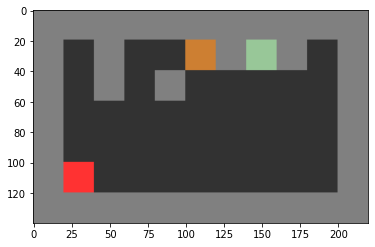

In [9]:
o = e.reset()
plt.imshow(e.render('rgb_array'))

In [ ]:
plot_res(pee_teacher.agent_train_entropy, "trainee_entropy")

In [ ]:
env = pee_teacher.create_envs(1)[0]
plt.imshow(env.render('rgb_array'))

# RESULTS CHECK

In [43]:
env = pee_teacher.create_envs(1)[0]

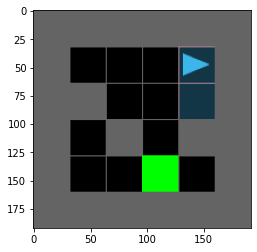

In [21]:
env.reset_random()
plt.imshow(env.render('rgb_array'))

In [34]:
env = test_envs["Cluttered40Minigrid"]()

In [ ]:
#pen_agent, p_agent, r_agent, pee_agent

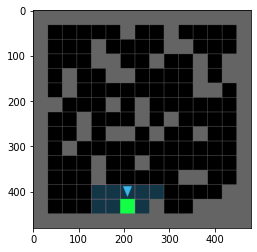

2 0.33399999999999996 True
evaluation episode: 0 R: 0.33399999999999996


In [35]:
agent = pee_agent
agent.set_eval_mode()
vid = []
for i in range(1):
    obs = env.reset()
    # break
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        clear_output(wait=True)
        frame = env.render('rgb_array')
        vid.append(frame)
        plt.imshow(frame)
        plt.show()
        # env.render(mode='rgb_array')
        # env.render()
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        print(action, r, done)

        R += r
        t += 1
        reset = t == 500
        time.sleep(0.01)

        if done or reset:
            break
    print('evaluation episode:', i, 'R:', R)

In [418]:
save_vid(vid,'test')

In [376]:
def save_vid(frames, vid_name):
    out = cv2.VideoWriter(vid_name+'.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (800,640))
 
    for i in range(len(frames)):
        frame = cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR)
        frame = cv2.resize(frame, (800,640))
        out.write(frame)
    out.release()

# Curriculum results

In [12]:
def run_agent(agent, env, num_iters=1, plot=False):
    agent.set_eval_mode()
    mean_r = 0
    for i in range(num_iters):
        obs = env.reset()
        # break
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            if plot:
                clear_output(wait=True)
                plt.imshow(env.render('rgb_array'))
                plt.show()
                time.sleep(0.01)

            # env.render(mode='rgb_array')
            # env.render()
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)

            R += r
            t += 1
            reset = t == 500

            if done or reset:
                break
        mean_r +=R
    return mean_r / num_iters

In [13]:
runable_envs = {}
for env_name in get_all_avail_test_envs():
    try:
        test_env = test_envs[env_name]()
        runable_envs[env_name] = test_env
    except:
        print("Exception",env_name, test_env.minigrid_mode)

In [25]:
agents = {"paired_entropy": pen_agent, "paired":p_agent, "random":r_agent, "entropy_only":pee_agent, "entropy_history": peh_agent, "paired_entropy_history": penh_agent}

In [26]:
def calc_result(agents, runable_envs):
    i=0
    all_results = np.zeros((len(runable_envs), len(agents)))
    for env_name,env in runable_envs.items():
        print(env_name, i, len(runable_envs))
        j= 0
        for a_name, a in agents.items():
            env.__init__()
            res = run_agent(a, env)
            all_results[i][j] = res
            j+=1
        i+=1
    return all_results

In [27]:
all_results = calc_result(agents, runable_envs)

Cluttered40Minigrid 0 28
Cluttered10Minigrid 1 28
Cluttered50Minigrid 2 28
Cluttered5Minigrid 3 28
Cluttered1MinigridMini 4 28
Cluttered6MinigridMini 5 28
Cluttered7MinigridMini 6 28
ClutteredMinigridLava 7 28
ClutteredMinigridLavaMini 8 28
ClutteredMinigridLavaMedium 9 28
Cluttered15MinigridMedium 10 28
EmptyRandomEnv6x6Minigrid 11 28
EmptyRandomEnv15x15Minigrid 12 28
TwoRoomsEnvMinigrid 13 28
FourRoomsEnvMinigrid 14 28
MiniTwoRoomsEnvMinigrid 15 28
MiniFourRoomsEnvMinigrid 16 28
MazeEnv 17 28
MiniMazeEnv 18 28
MediumMazeEnv 19 28
HorizontalMazeEnv 20 28
Maze3Env 21 28
LabyrinthEnv 22 28
Labyrinth2Env 23 28
SixteenRoomsEnv 24 28
SixteenRoomsFewerDoorsEnv 25 28
NineRoomsEnv 26 28
NineRoomsFewerDoorsEnv 27 28


In [ ]:
all_results

In [28]:
clean_env_names = np.array(list(runable_envs.keys()))[~np.all(all_results == 0, axis=1)]
clean_res = all_results[~np.all(all_results == 0, axis=1)]

In [29]:
plot_test_res_all(clean_res, clean_env_names, agents)

Opening in existing browser session.


In [31]:
print_mean_score(all_results, agents)

paired_entropy_mean: 0.36001785714285717
paired_mean: 0.17899642857142858
random_mean: 0.3785392857142857
entropy_only_mean: 0.3415750000000001
entropy_history_mean: 0.31835
paired_entropy_history_mean: 0.35960714285714285


In [20]:
def print_mean_score(all_results, agents):
    scores = np.mean(all_results, axis=0)
    for i,a in enumerate(agents):
        print(f"{a}_mean:", scores[i])

In [21]:
from plotly.subplots import make_subplots
from plotly import graph_objects as go
def plot_test_res_all(data_array, env_names, agents_dict):
    color10_16 = ['violet', 'orange', 'cyan', "green",  "yellow"]
    col_len = int(np.sqrt(len(env_names)))
    row_len = (col_len + len(env_names) - col_len**2)
    fig = make_subplots(rows=row_len, cols=col_len, subplot_titles=env_names)
    for i,env_name in enumerate(env_names):
        fig.add_trace(
            go.Bar(
                name=env_name,
                x=list(agents_dict.keys()),
                y=data_array[i],
                marker_color=color10_16
            ),
            row=(i // col_len) +1 ,
            col =(i % col_len)+1,
            
        )
    fig.update_layout(height=1600, width=1600, title_text="Reward Comparation", showlegend=False, legend=dict(
    yanchor="bottom",
    y=-0.5,
    xanchor="right",
    x=1
))
    fig.show()

# FOR DEBUG

In [ ]:
o=env.reset()
agent = pee_agent
agent.reset_rnn_hidden()
# o = env.reset()
v= agent.pre_process_obs_for_act(o,1)
agent.critic_model(v)

o,_,_,_ = env.step(2)
plt.imshow(env.render('rgb_array'))